# Машинное обучение, DS-поток, осень 2024
## Задание ML.9

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Правила оформления теоретических задач:**

В задании требуется вывести формулы для обратного прохода.
* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов

**Баллы за задание**  
    1. Простая нейронная сеть &mdash; **40 баллов**  
    2. BatchNorm &mdash; **80 баллов**  
    3. Dropout &mdash; **50 баллов**  
    4. Регуляризация весов &mdash; **30 баллов**  
    5. Затухание градиента &mdash; **40 баллов**  
    6. Выводы &mdash; **10 баллов**  
    
 Всего &mdash;   **250 баллов**.

In [263]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')

from torchvision.datasets import FashionMNIST

In [264]:
# Bot check

# HW_ID: ds_ml9
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [265]:
from torch import nn
import torch
from IPython.display import clear_output

import numpy as np
from torch.utils.data import DataLoader
import random


В данном задании вам предстоит проверить на практике эффективность методов, представленных на лекции на одном из базовых датасетов для нейронных сетей. Естественно, обобщать наблюдения нельзя, но некоторые тенденции вы сможете заметить.

**Совет**

Это задание будет быстрее выполнить на GPU. Чтобы не тратить много времени на GPU (важно на Google Colab), **проверяйте работоспособность кода на CPU на маленьком объеме данных**, где это возможно, а затем переходите на GPU.

### 0. Данные
Будем использовать набор данных **Fasion MNIST**. Скачаем тренировочный и тестовый наборы данных.

In [266]:
train_source = FashionMNIST('fasionmnist', download=True, train=True)
test_source = FashionMNIST('fasionmnist', download=True, train=False)

Он содержит 60 000 изображений в тренировочной части данных и 10 000 в тестовой.

In [267]:
len(train_source.data), len(test_source.data)

(60000, 10000)

В датасете содержится 10 классов одежды.

In [268]:
train_source.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Можно посмотреть их названия.

In [269]:
train_source.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Проиллюстрируем набор данных.

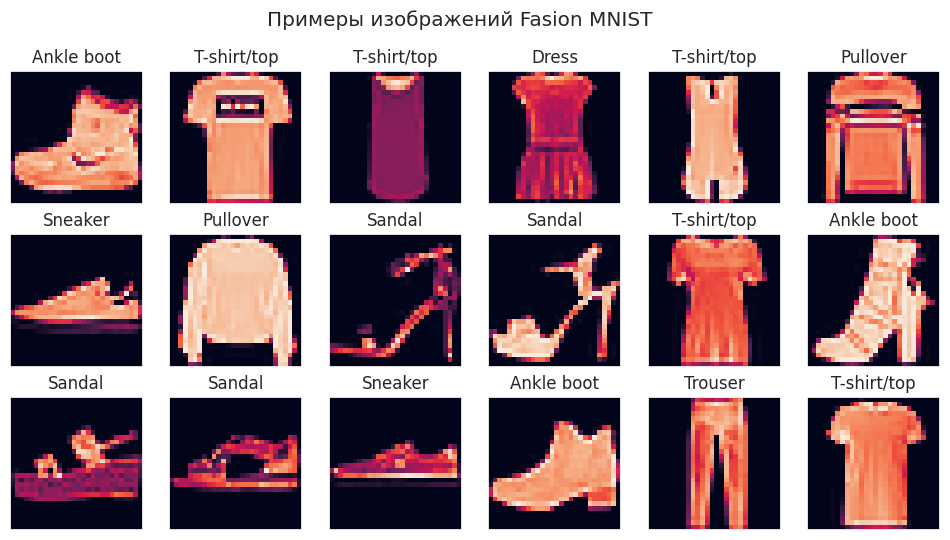

In [270]:
fig, axs = plt.subplots(3, 6, figsize=(12, 6))
for k, (image, label) in enumerate(zip(train_source.data[:18], train_source.targets[:18])):
    i, j = k // 6, k % 6
    axs[i][j].imshow(image)
    axs[i][j].grid()
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    axs[i][j].set_title(train_source.classes[label])
fig.suptitle('Примеры изображений Fasion MNIST')
plt.show()

### 1. Простая полносвязная нейронная сеть

Сначала вспомним функцию обучения модели, которую мы уже много раз использовали.

In [271]:
import time
from collections import defaultdict
from tqdm import tqdm


In [272]:
def train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs,
    device,
    checkpoint_path='model.pt',
):
    """
    # Обучение модели
    """
    start_time = time.time()

    history = defaultdict(lambda: defaultdict(list))
    best_val_acc = 0.

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        train_size, val_size = 0, 0

        model.train()  # устанавливаем поведение dropout / batch_norm  в обучение
        model.to(device)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.detach() * len(y_batch)
            y_pred = torch.argmax(logits, axis=1).detach()
            train_acc += (y_batch == y_pred).sum()
            train_size += len(y_batch)

        # Подсчитываем лоссы и точность, сохраняем в "историю"
        train_loss = train_loss.cpu().numpy() / train_size
        train_acc = train_acc.cpu().numpy() / train_size
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # Устанавливаем поведение dropout / batch_norm в тестирование
        model.eval()

        # Полный проход по валидации
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                val_loss += loss.detach() * len(y_batch)
                y_pred = torch.argmax(logits, axis=1).detach()
                val_acc += (y_batch == y_pred).sum()
                val_size += len(y_batch)

        # Подсчитываем лоссы и сохраняем в "историю"
        val_loss = val_loss.cpu().numpy() / val_size
        val_acc = val_acc.cpu().numpy() / val_size
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        # Сохраняем лучшую модель по метрике на валидации
        if val_acc > best_val_acc:
            torch.save({
                'model': model.state_dict(),
                'optim': optimizer.state_dict(),
                }, checkpoint_path)

        clear_output()
        # Печатаем результаты после каждой эпохи
        print("Эпоха {} из {}, время {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time
        ))
        print("  loss на обучении (на итерации): \t{:.6f}".format(train_loss))
        print("  loss на валидации (на итерации): \t{:.6f}".format(val_loss))
        print("  accuracy на обучении: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  accuracy на валидации: \t\t\t{:.2f} %".format(val_acc * 100))

    return history

Постройте простую полносвязную двухслойную нейронную сеть с функцией активации ReLU. Обучите ее на тренировочной части данных. Можете использовать `SimpleDataset()` из семинара. Используйте кросс-энтропию в качестве функции ошибки. Добейтесь хотя бы 0.87 accuracy на тестовой части данных.

In [273]:
class SimpleDataset():
    """
    Простой итерируемый датасет.
    """
    def __init__(self, X_data, y_data):
        assert len(X_data) == len(y_data)
        self.x = X_data
        self.y = y_data

    def __len__(self):
        """
        Размер датасета.
        """
        return len(self.y)

    def __getitem__(self, idx):
        """
        Обращение к элементу датасета по индексу.
        """
        xi = self.x[idx].ravel().float()
        yi = self.y[idx].long()
        return xi, yi

In [274]:
print(train_source.data.shape)
print(train_source.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [275]:
train_dataset = SimpleDataset(train_source.data, train_source.targets)
test_dataset = SimpleDataset(test_source.data, test_source.targets)

batch_size = 64

num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Проверим, что все работает корректно

In [276]:
x_batch, y_batch = next(iter(train_loader))
print(x_batch.shape)
print(y_batch.shape)

torch.Size([64, 784])
torch.Size([64])


In [277]:
mymodel = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mymodel.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = train(
    mymodel,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    num_epochs=5,
    device=device,
)  # todo make 87 accuracy

KeyboardInterrupt: 

Визуализируйте "вероятности" предскаазнных моделью классов для нескольких изображений из теста. Для этого нужно применить SoftMax к выходам модели.

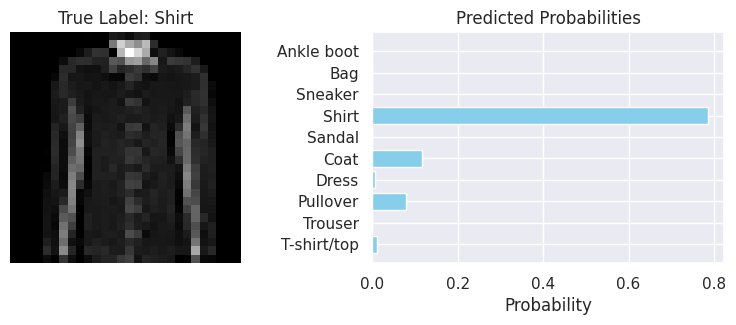

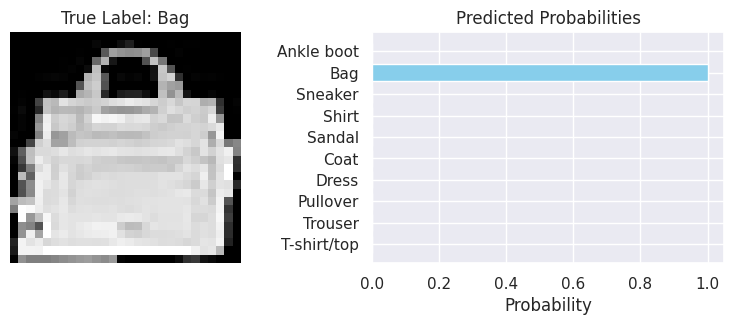

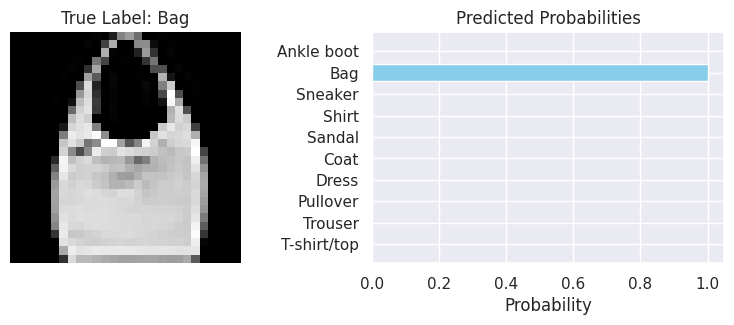

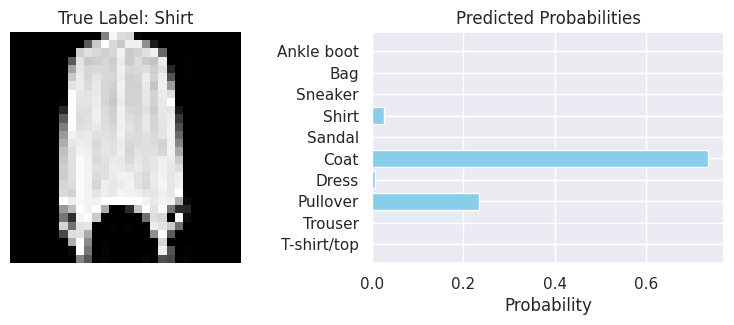

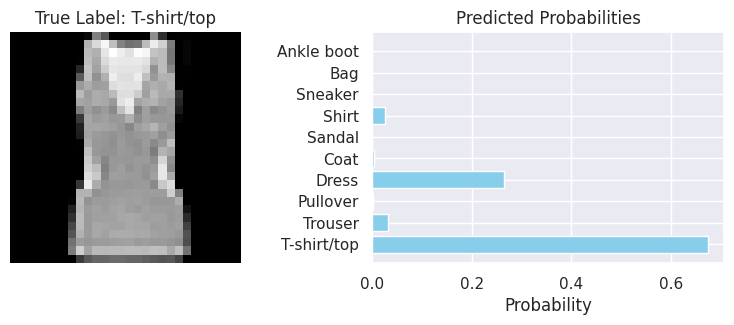

In [123]:
def visualize_predictions(model, test_loader, class_names, num_images=5):
    model.eval()  # Переводим модель в режим оценки
    images_shown = 0
    
    all_indices = list(range(len(test_loader.dataset)))
    random_indices = random.sample(all_indices, num_images)
    current_idx = 0

    # Итерируем по данным из test_loader
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            # Получаем предсказания
            y_pred = model(x_batch)
            y_pred_softmax = torch.softmax(y_pred, dim=1)

            x_batch = x_batch.cpu()
            y_pred_softmax = y_pred_softmax.cpu().numpy()
            y_batch = y_batch.cpu().numpy()

            for i in range(len(x_batch)):
                if current_idx in random_indices:
                    image = x_batch[i].squeeze().reshape(28, 28)
                    probs = y_pred_softmax[i]
                    true_label = y_batch[i]

                    # Визуализация изображения и вероятностей
                    plt.figure(figsize=(10, 3))
                    plt.subplot(1, 2, 1)
                    plt.imshow(image, cmap="gray")
                    plt.axis('off')
                    plt.title(f"Настоящая метка: {class_names[true_label]}")
                    
                    # Визуализация вероятностей
                    plt.subplot(1, 2, 2)
                    plt.barh(class_names, probs, color='skyblue')
                    plt.xlabel("Вероятность")
                    plt.title("Предсказанные вероятности")

                    plt.show()

                    images_shown += 1
                    if images_shown >= num_images:
                        return
                
                current_idx += 1

class_names = train_source.classes
visualize_predictions(mymodel, test_loader, class_names, num_images=5)


### 2. BatchNorm

Проверьте два варианта включения BatchNorm в архитектуру двухслойной сети: до функции активации и после нее. В итоге получается 2 модели:
```
(1) Linear -> BatchNorm -> ReLU -> Linear
(2) Linear -> ReLU -> BatchNorm -> Linear
```
Обучите обе модели. Постройте графики распределений выходов первого, второго и третьего слоя сети (т.е. всех кроме последнего) для каждой модели до обучения, в процессе обучения и после обучения. Сравните эти графики с соответствующими графиками модели без BatchNorm. В этом пункте все графики распределений лучше строить с помощью `kdeplot`.

In [220]:
class BmReluModel(nn.Module):
    def __init__(self):
        super(BmReluModel, self).__init__()
        self.linear1 = nn.Linear(28 * 28, 100)
        self.linear2 = nn.Linear(100, 10)
        self.batchnorm1 = nn.BatchNorm1d(100)

        self.layer1 = None
        self.layer2 = None
        self.layer3 = None

    def forward(self, x):
        self.layer1 = self.linear1(x)
        self.layer2 = self.batchnorm1(self.layer1)
        self.layer3 = nn.ReLU()(self.layer2)
        x = self.linear2(self.layer3)

        return x


class ReluBmModel(nn.Module):
    def __init__(self):
        super(ReluBmModel, self).__init__()
        self.linear1 = nn.Linear(28 * 28, 100)
        self.linear2 = nn.Linear(100, 10)
        self.batchnorm1 = nn.BatchNorm1d(100)

        self.layer1 = None
        self.layer2 = None
        self.layer3 = None

    def forward(self, x):
        self.layer1 = self.linear1(x)
        self.layer2 = nn.ReLU()(self.layer1)
        self.layer3 = self.batchnorm1(self.layer2)
        x = self.linear2(self.layer3)
        return x


class NoBmModel(nn.Module):
    def __init__(self):
        super(NoBmModel, self).__init__()
        self.linear1 = nn.Linear(28 * 28, 100)
        self.linear2 = nn.Linear(100, 10)

        self.layer1 = None
        self.layer2 = None
        self.layer3 = None

    def forward(self, x):
        self.layer1 = self.linear1(x)
        self.layer2 = nn.ReLU()(self.layer1)
        x = self.linear2(self.layer2)
        return x

In [221]:
models = {
    # модель без батч-нормализации
    'no_bn': NoBmModel(),
    # модель с батч-нормализацией
    'bn_relu': BmReluModel(),
    'relu_bn': ReluBmModel(),
}


In [222]:
def calc_outputs(model, device, input_tensor, batch_size):
    '''Считает выходы модели после 1, 2 и 3 слоев.
    Возвращает 3 тензора.'''

    input_tensor = input_tensor.reshape(batch_size, -1)
    model.to(device)
    model(input_tensor.float().to(device))
    
    return model.layer1, model.layer2, model.layer3


Будем записывать выходы модели в `outputs`.

In [223]:
outputs = {name: {'l1': {}, 'l2': {}, 'l3': {}} for name in ('relu_bn', 'no_bn', 'bn_relu')}

batch_size = 64

In [224]:
x_batch, y_batch = next(iter(train_loader))
for model_name, model in models.items():
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # выходы слоев перед обучением
    outputs[model_name]['l1']['init'] = calc_outputs(model, device, x_batch, batch_size)
    outputs[model_name]['l2']['init'] = calc_outputs(model, device, x_batch, batch_size)
    outputs[model_name]['l3']['init'] = calc_outputs(model, device, x_batch, batch_size)

    train(model, criterion, optimizer, train_loader, test_loader, num_epochs=5, device=device)

    # выходы слоев во время обучения во время обучения
    outputs[model_name]['l1']['train'] = calc_outputs(model, device, x_batch, batch_size)
    outputs[model_name]['l2']['train'] = calc_outputs(model, device, x_batch, batch_size)
    outputs[model_name]['l3']['train'] = calc_outputs(model, device, x_batch, batch_size)

    train(model, criterion, optimizer, train_loader, test_loader, num_epochs=5, device=device)

    # выходы слоев после обучения модели
    outputs[model_name]['l1']['final'] = calc_outputs(model, device, x_batch, batch_size)
    outputs[model_name]['l2']['final'] = calc_outputs(model, device, x_batch, batch_size)
    outputs[model_name]['l3']['final'] = calc_outputs(model, device, x_batch, batch_size)

100%|██████████| 5/5 [02:52<00:00, 34.50s/it]

Epoch 5 of 5. Total time 172.510s
  training loss (in-iteration): 	0.283192
  validation loss (in-iteration): 	0.909277
  training accuracy: 			89.54 %
  validation accuracy: 			87.25 %


In [225]:
models["no_bn"].layer3

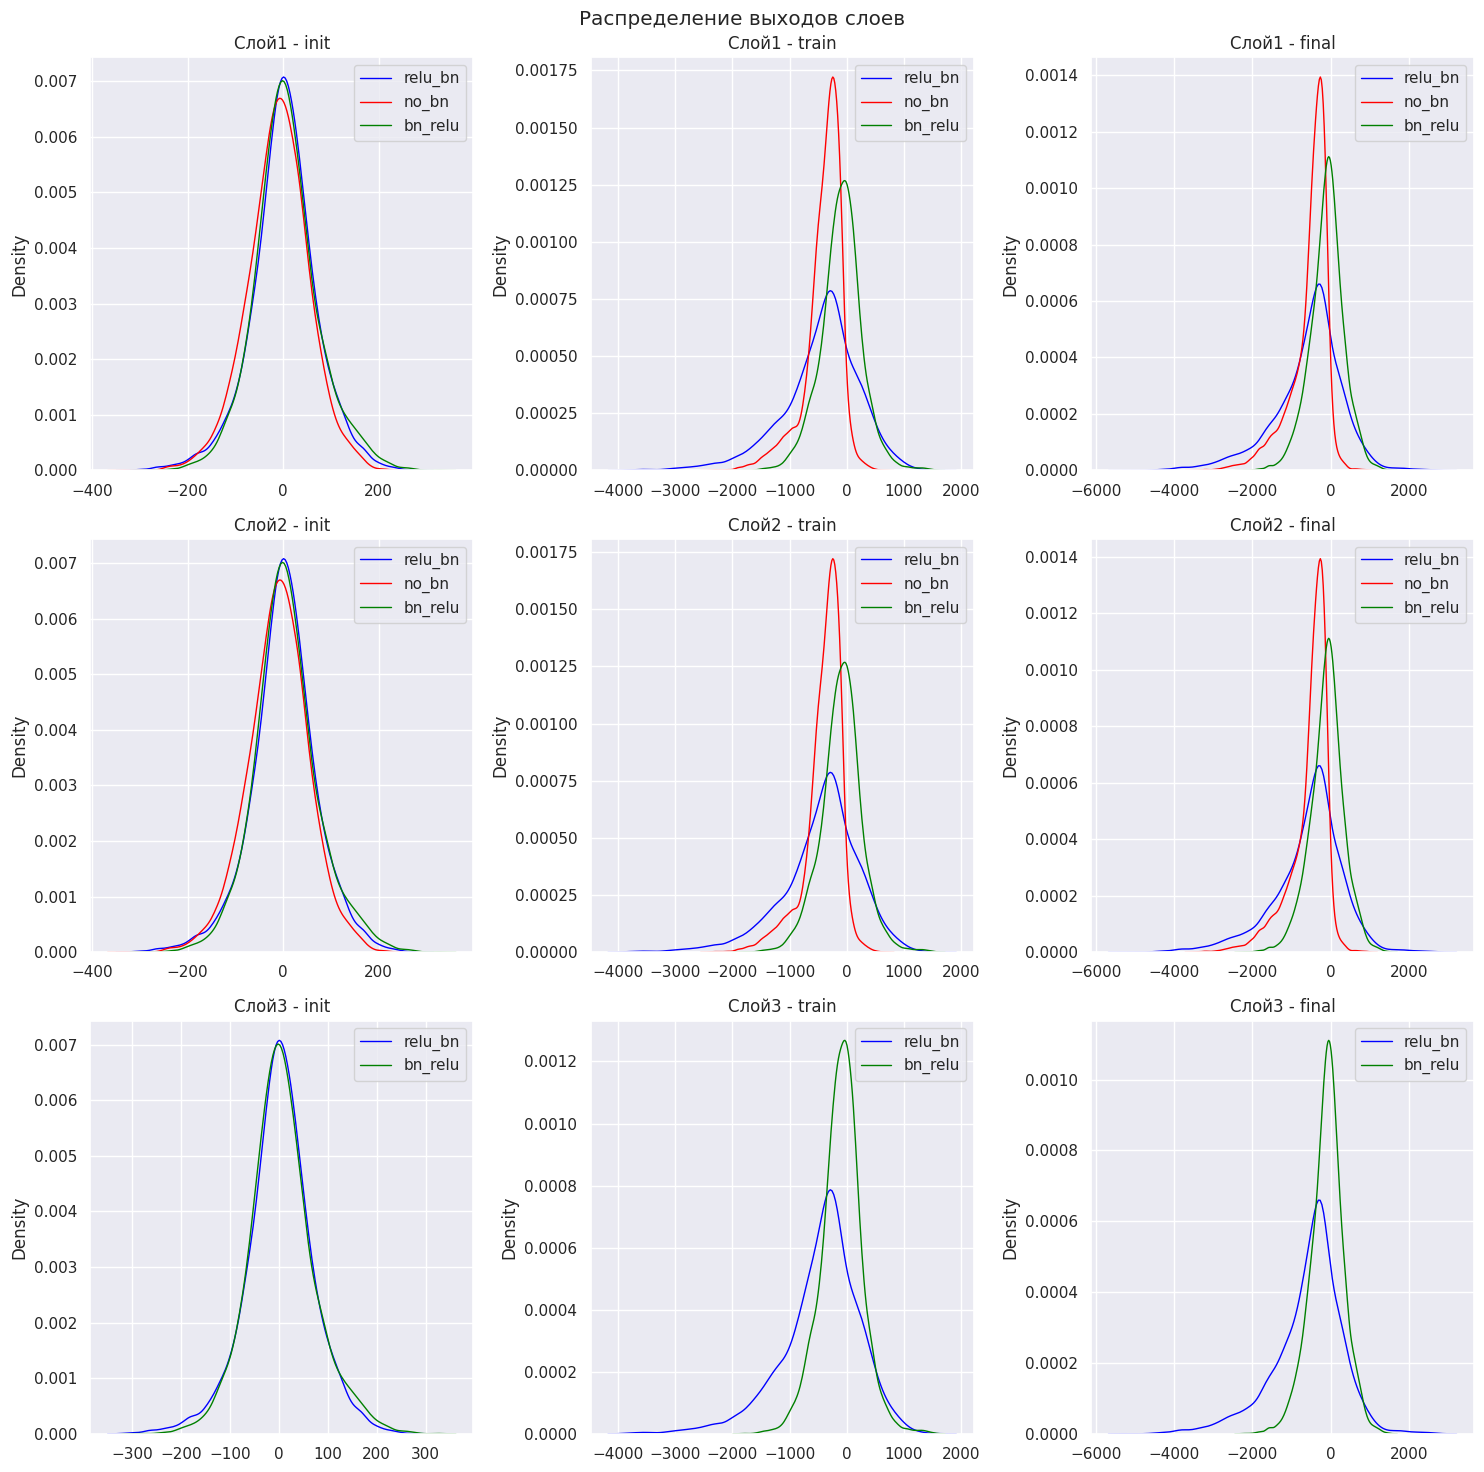

In [228]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Распределение выходов слоев')

# Define colors for each model
colors = {
    'relu_bn': 'blue',
    'no_bn': 'red', 
    'bn_relu': 'green'
}

for i, layer in enumerate(['l1', 'l2', 'l3']):
    for j, stage in enumerate(['init', 'train', 'final']):
        ax = axes[i][j]
        
        for model_name in outputs.keys():
            if model_name == "no_bn" and layer == "l3":
                continue
            layer_output = outputs[model_name][layer][stage][0].detach().cpu().numpy().flatten()
            sns.kdeplot(data=layer_output, ax=ax, label=model_name, color=colors[model_name], linewidth=1)
        
        ax.set_title(f'Слой{i+1} - {stage}')
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()

**Вывод:**

Первый слой:

* Перед обучением: Распределения relu_bn и bn_relu почти совпадают, no_bn имеет сдвиг, причем ее точки распределены менее плотно.
* В течении обучения и после обучения: no_bn и relu_bn имеют ярко выраженый сдвиг, то есть мы не смогли нормализовать данные. bn_relu демонстрирует корректно нормализованные данные.

Ту же картину наблюдаем во втором и третьем слоях.

Значит для корректной нормализации надо использовать сначала BatchNorm, а только потом функцию активации, что логично, ведь при использовании функции активации мы теряем информацию из перцептрона.
    

Обучите оба варианта модели с BatchNorm с разными инициализациями хотя бы 3 раза. Инициализации должны отличаться только random state. Сравните качество моделей по loss и accuracy в зависимости от номера итерации.

In [233]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


def train_with_different_seeds(seed, train_loader, test_loader, num_epochs=5):
    results = {"loss": [], "acc": []}

    set_random_seed(seed)
    model = BmReluModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    history = train(
        model,
        criterion,
        optimizer,
        train_loader,
        test_loader,
        num_epochs,
        device=device,
    )

    results["loss"].append(history["loss"])
    results["acc"].append(history["acc"])

    return model, results

In [234]:
seeds = random.sample(range(1000), 3)
results = []
models = []
for seed in seeds:
    model, result = train_with_different_seeds(seed, train_loader, test_loader, num_epochs=5)
    models.append(model)
    results.append(result)


100%|██████████| 5/5 [02:12<00:00, 26.55s/it]

Epoch 5 of 5. Total time 132.750s
  training loss (in-iteration): 	0.284312
  validation loss (in-iteration): 	0.380627
  training accuracy: 			89.58 %
  validation accuracy: 			85.91 %


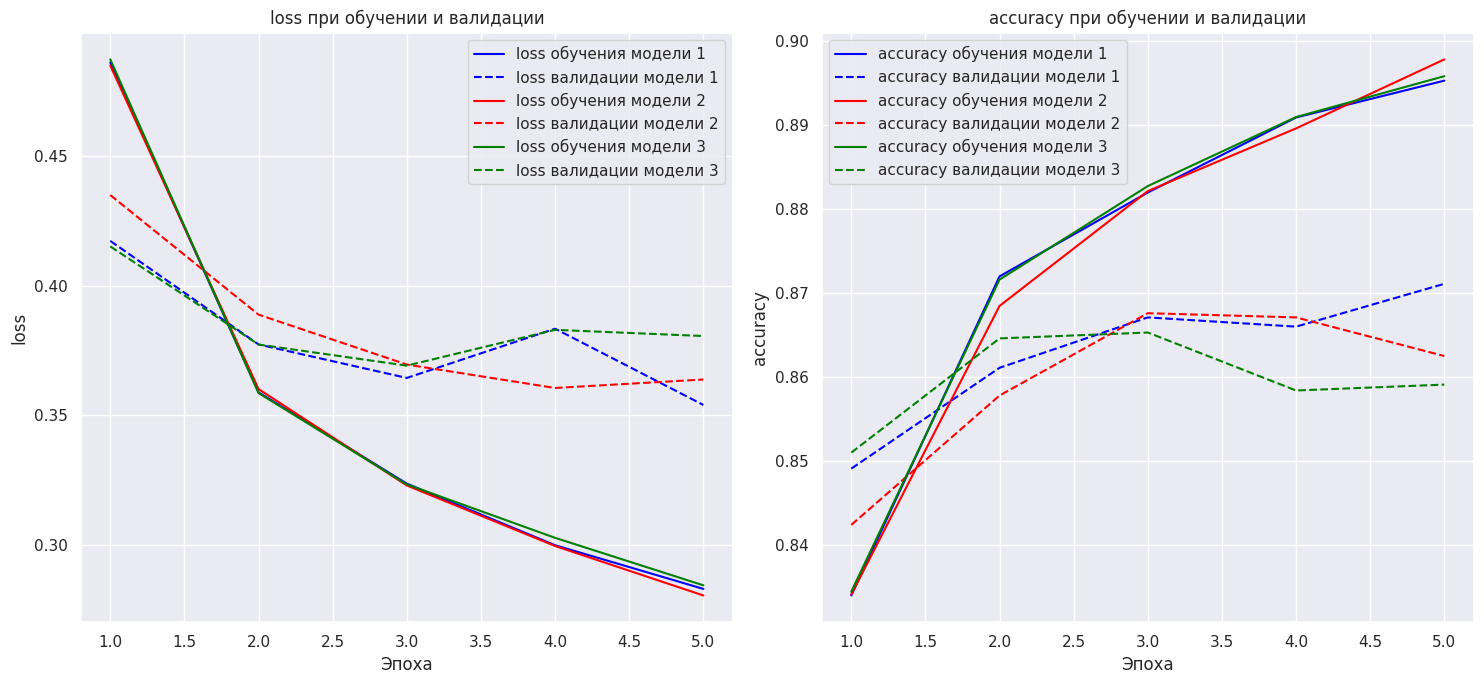

In [255]:
def plot_histories_multiple(results, title=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    colors = ["blue", "red", "green"]
    for i, result in enumerate(results):
        train_loss = result["loss"][0]["train"]
        val_loss = result["loss"][0]["val"]
        train_acc = result["acc"][0]["train"]
        val_acc = result["acc"][0]["val"]

        epochs = range(1, len(train_loss) + 1)

        ax1.plot(
            epochs, train_loss, color=colors[i], label=f"loss обучения модели {i+1}"
        )
        ax1.plot(
            epochs,
            val_loss,
            color=colors[i],
            label=f"loss валидации модели {i+1}",
            linestyle="--",
        )

        ax2.plot(
            epochs, train_acc, color=colors[i], label=f"accuracy обучения модели {i+1}"
        )
        ax2.plot(
            epochs,
            val_acc,
            color=colors[i],
            label=f"accuracy валидации модели {i+1}",
            linestyle="--",
        )

    ax1.set_xlabel("Эпоха")
    ax1.set_ylabel("loss")
    ax1.legend()
    ax1.grid(True)
    ax1.set_title("loss при обучении и валидации")

    ax2.set_xlabel("Эпоха")
    ax2.set_ylabel("accuracy")
    ax2.legend()
    ax2.grid(True)
    ax2.set_title("accuracy при обучении и валидации")

    plt.tight_layout()
    plt.show()


plot_histories_multiple(results)

Выберите лучшую обученную модель с BatchNorm. Посмотрите на распределение выходов слоя до BatchNorm и самого BatchNorm для нескольких батчей из тестовой части данных. Согласуются ли результаты с утверждением, что BatchNorm решает проблему ковариантного сдвига для батчей?



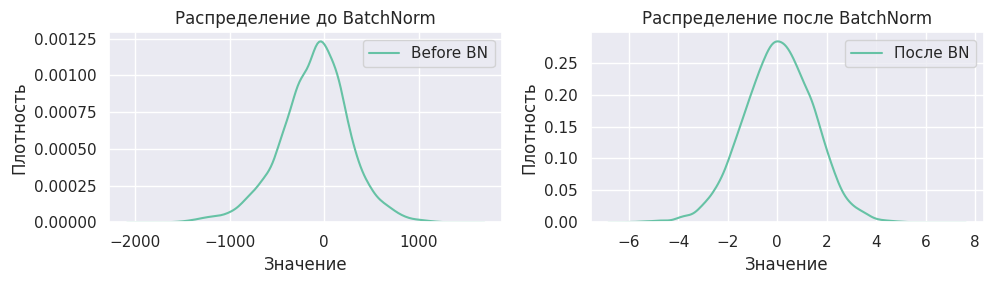

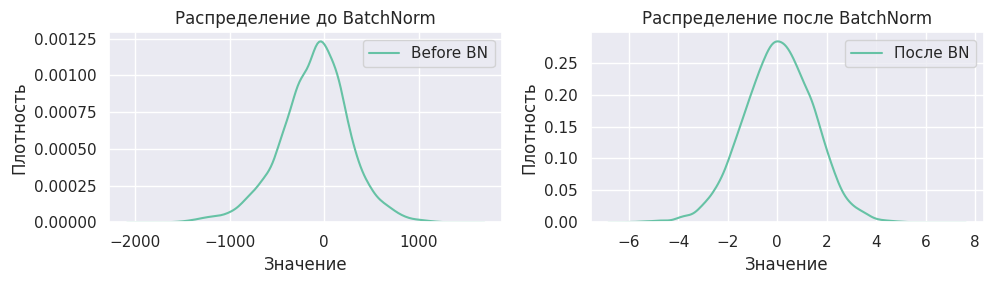

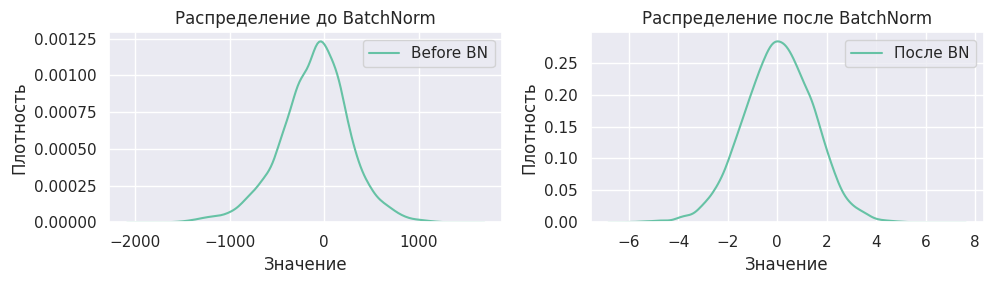

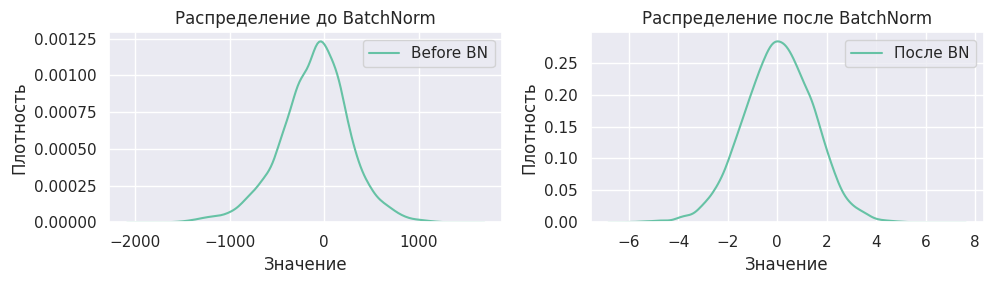

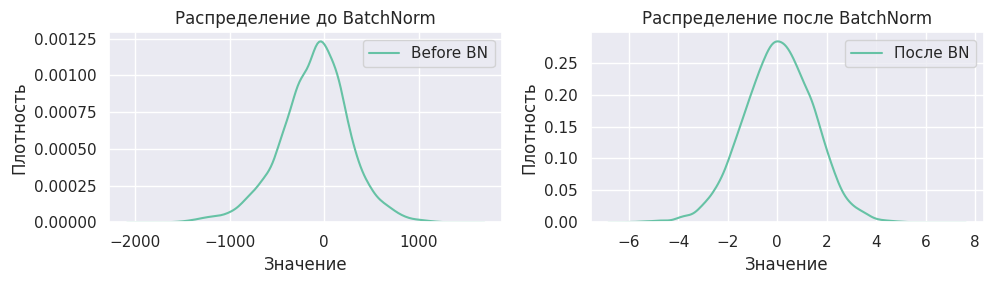

In [283]:
# Так как мы занимаемся классификацией, то разумно в качестве лучшей модели выбрать модель с наибольшей accuracy на валидации.
best_model = models[np.argmax([result["acc"][0]["val"][-1] for result in results])]

n_runs = 5
for _ in range(n_runs):
    x_batch, y_batch = next(iter(test_loader))
    outputs = calc_outputs(best_model, device, x_batch, batch_size)

    before_bn = outputs[0]
    after_bn = outputs[1]

    plt.figure(figsize=(10, 3))

    plt.subplot(1, 2, 1)
    sns.kdeplot(data=before_bn.detach().numpy().flatten(), label='Before BN')
    plt.title('Распределение до BatchNorm')
    plt.xlabel('Значение')
    plt.ylabel('Плотность')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2) 
    sns.kdeplot(data=after_bn.detach().numpy().flatten(), label='После BN')
    plt.title('Распределение после BatchNorm')
    plt.xlabel('Значение')
    plt.ylabel('Плотность')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

**Ответ:** Как видим, BatchNorm действительно переводит данное распределение к стандратному нормальному, что согласуется с теорией. Таким образом, BatchNorm действительно решает проблему ковариантного сдвига для батчей.

### 3. Dropout
Для начала добьемся переобучения модели. Это можно сделать, если использовать больше параметров в слое, дольше обучать или поменять параметры оптимизатора. Например, так:

In [285]:
model = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-3,
)
DO_histories = []
DO_histories.append(
    train(
        model,
        criterion,
        optimizer,
        train_loader,
        test_loader,
        num_epochs=3,
        device=device,
    )
)

Эпоха 3 из 3, время 126.289s
  loss на обучении (на итерации): 	0.535601
  loss на валидации (на итерации): 	0.533069
  accuracy на обучении: 			81.44 %
  accuracy на валидации: 			81.89 %


In [314]:
def plot_histories(results, title="", labels=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    colors = ["blue", "red", "green", "orange", "purple", "brown", "pink", "gray", "cyan", "magenta", "lime", "olive", "teal", "navy", "maroon", "gold", "violet", "indigo", "coral", "darkgreen"]

    for i, result in enumerate(results):
        train_loss = result["loss"]["train"]
        val_loss = result["loss"]["val"]
        train_acc = result["acc"]["train"]
        val_acc = result["acc"]["val"]

        epochs = range(1, len(train_loss) + 1)

        ax1.plot(
            epochs, train_loss, color=colors[i], label=f"loss обучения модели {labels[i]}"
        )
        ax1.plot(
            epochs,
            val_loss,
            color=colors[i],
            label=f"loss валидации модели {labels[i]}",
            linestyle="--",
        )

        ax2.plot(
            epochs, train_acc, color=colors[i], label=f"accuracy обучения модели {labels[i]}"
        )
        ax2.plot(
            epochs,
            val_acc,
            color=colors[i],
            label=f"accuracy валидации модели {labels[i]}",
            linestyle="--",
        )

    ax1.set_xlabel("Эпоха")
    ax1.set_ylabel("loss")
    ax1.legend()
    ax1.grid(True)
    ax1.set_title("loss при обучении и валидации")

    ax2.set_xlabel("Эпоха")
    ax2.set_ylabel("accuracy")
    ax2.legend()
    ax2.grid(True)
    ax2.set_title("accuracy при обучении и валидации")

    plt.tight_layout()
    plt.show()

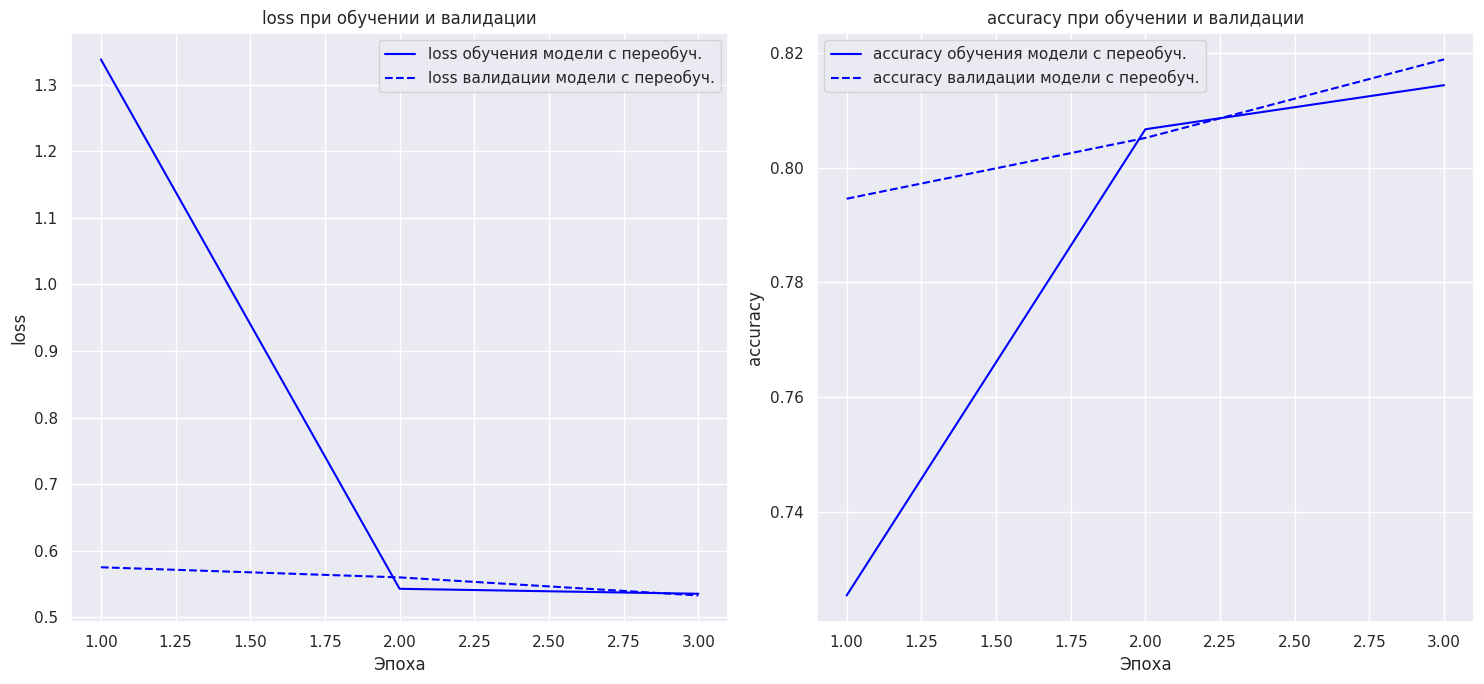

In [315]:
plot_histories(DO_histories, 'модель с переобуч.', ['с переобуч.'])


Добавьте Dropout в модель. Сравните скорость обучения и качество моделей в зависимости от параметра $p$ в Dropout.

In [ ]:
p_values = [p for p in np.linspace(0.1, 0.5, 5)]

for p in tqdm(p_values):
    model = nn.Sequential(
        nn.Linear(28 * 28, 100),
        nn.ReLU(),
        nn.Dropout(p=p),
        nn.Linear(100, 10),
    )
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=2e-3,
    
    )
    
    DO_histories.append(
        train(
            model,
            criterion,
            optimizer,
            train_loader,
            test_loader,
            num_epochs=60,
            device=device,
        )
    )

In [ ]:
plot_histories(DO_histories[1:], 'модель с Dropout', [f'p={p:.1f}' for p in p_values])

Измерьте, насколько переобучаются модели в каждом случае - для этого посчитайте среднюю разность лосса на валидации и трейне (со знаком) на последних 10 или 20 эпохах.

In [317]:
diff_depend_of_p = dict()
new_p_values = [0] + p_values

for i, result in enumerate(DO_histories):
    tmp_diff = np.mean(
        np.array(result["loss"]["train"][-10:]) - np.array(result["loss"]["val"][-10:])
    )
    diff_depend_of_p[new_p_values[i]] = tmp_diff

for p in diff_depend_of_p.keys():
    print(
        f"Для p={p:.1f} средняя разность лосса на валидации и трейне на последних 10 эпохах равна {diff_depend_of_p[p]:.4f}"
    )

**Вывод:** ...

### 4. Регуляризация весов
Проверьте распределение весов переобученной модели в пункте 3. Попробуйте добиться такого эффекта переобучения, при котором возникают большие значения некоторых весов. Даже если не получится, нужно показать, что вы пытались ;)

In [318]:
model_kaiming = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)

for name, param in model_kaiming.named_parameters():
    if name.find('weight') != -1:
        param.data = nn.init.kaiming_uniform_(
            param.data, nonlinearity='relu'
        )

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-3,
)

DO_histories = []
DO_histories.append(
    train(
        model_kaiming,
        criterion,
        optimizer,
        train_loader,
        test_loader,
        num_epochs=60,
        device=device,
    )
)

KeyboardInterrupt: 

Примените L2-регуляризацию при обучении модели. Для этого нужно указать коэффициент регуляризации через параметр `weight_deacay` в оптимизаторе. Напоминаем, если вы хотите использовать `Adam`, то его нужно поменять на `AdamW`, так как в `Adam` регуляризация реализована не совсем корректно. Покажите, что проблема больших весов решается.

**Вывод:** ...

### 5. Затухание градиента

Продемонстрируем эффект затухания градиента. Для этого будем визуализировать долю градиентов близких к нулю на каждом слое в течение обучения. Добавим в функцию обучения подсчет доли околонулевых градиентов:

In [319]:
def train_count_zero_grads(
        model,
        criterion,
        optimizer,
        train_loader,
        val_loader,
        num_epochs,
        device,
        checkpoint_path=None,
):
    """
    # Обучение модели
    """
    start_time = time.time()
    history = defaultdict(lambda: defaultdict(list))
    best_val_acc = 0.
    model.train()
    model.to(device)

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        train_size, val_size = 0, 0

        model.train()  # устанавливаем поведение dropout / batch_norm в обучение
        model.to(device)
        
        zero_grads = defaultdict(float) # количество околонулевых градиентов
        n_grads = defaultdict(int) # количество градиентов всего

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            for name, param in model.named_parameters():
                # Будем считать градиент околонулевым, если его модуль меньше 1e-5
                zero_grads[name] += (param.grad.abs() < 1e-5).sum().item()
                n_grads[name] += param.grad.numel()


            train_loss += loss.detach() * len(y_batch)
            y_pred = torch.argmax(logits, axis=1).detach()
            train_acc += (y_batch == y_pred).sum()
            train_size += len(y_batch)

        # Подсчитываем лоссы и точность, сохраням в "историю"
        train_loss = train_loss.cpu().numpy() / train_size
        train_acc = train_acc.cpu().numpy() / train_size
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        for name, _ in model.named_parameters():
            mean_zero_grads = zero_grads[name] / n_grads[name]
            history['grad'][name].append(mean_zero_grads)

        # Устанавливаем поведение dropout / batch_norm  в тестирование
        model.eval()

        # Полный проход по валидации
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                val_loss += loss.detach() * len(y_batch)
                y_pred = torch.argmax(logits, axis=1).detach()
                val_acc += (y_batch == y_pred).sum()
                val_size += len(y_batch)

            # Подсчитываем лоссы и сохраням в "историю"
        val_loss = val_loss.cpu().numpy() / val_size
        val_acc = val_acc.cpu().numpy() / val_size
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        

        # Сохраняем лучшую модель по метрике на валидации
        if (checkpoint_path is not None) and (val_acc > best_val_acc):
            torch.save({
                'model': model.state_dict(),
                'optim': optimizer.state_dict(),
                }, checkpoint_path)
            best_val_acc = val_acc

        clear_output()
        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {}. Total time {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

    return history

Постройте более глубокую сеть, в качестве функций активации используйте гиперболический тангенс. Визуализируйте долю градиентов близких к нулю на каждом слое в течение обучения.

In [321]:
class DeepNN(nn.Module):
    def __init__(self, activation=nn.Tanh()):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 64)
        self.fc7 = nn.Linear(64, 64)
        self.fc8 = nn.Linear(64, 10)
        
        # В функции активации используем tanh
        self.activation = activation
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.activation(self.fc6(x))
        x = self.activation(self.fc7(x))
        x = self.fc8(x)
        return x

In [322]:
deep_model = DeepNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

history = train_count_zero_grads(
    deep_model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    num_epochs=3,
    device=device,
)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15, 7))

colors = ['blue', 'red', 'green', 'purple', 'orange']
layer_nums = set([name.split('.')[0][-1] for name in history['grad'].keys()])

for layer_num in layer_nums:
    layer_color = colors[int(layer_num)-1]
    for layer_name, grad_history in history['grad'].items():
        if layer_name.split('.')[0][-1] == layer_num:
            plt.plot(grad_history, label=layer_name, color=layer_color)

plt.xlabel('Epoch')
plt.ylabel('Fraction of Zero Gradients')
plt.title('Gradient Vanishing Analysis')
plt.legend()
plt.grid(True)
plt.show()


Попробуйте решить задачу затухания градиента с помощью использования функции активации LeakyReLU.

### Выводы
Обобщите результаты проведенных экспериментов.